# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [22]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data

from pymc_marketing.clv.models import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

Also consider these datasets: <br>
https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction<br>
https://www.kaggle.com/datasets/vijayuv/onlineretail

In [31]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"

raw_trans = pd.read_csv(url_cdnow)

raw_trans.head(5)

,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


In [39]:
df = clv_summary(raw_trans, 
            customer_id_col = "id", 
            datetime_col = "date",
            datetime_format = "%Y%m%d",
           )

cds = raw_trans.groupby("id")["cds_bought"].sum()
spent = raw_trans.groupby("id")["spent"].mean()

#df["cds_bought"] = cds

df = df.merge(cds, left_on = "id", right_index = True)
df = df.merge(spent, left_on = "id", right_index = True)

df = df.rename(columns = {"id": "customer_id"})

In [78]:
df.describe()

covar = ['cds_bought', 'spent']

len(df[covar].values)

2357

## Lifetimes Comparison

{'r': 0.5630234705473991,
 'alpha': 87.9162692182002,
 's': 0.4081228068115803,
 'beta': 73.60136858050433}

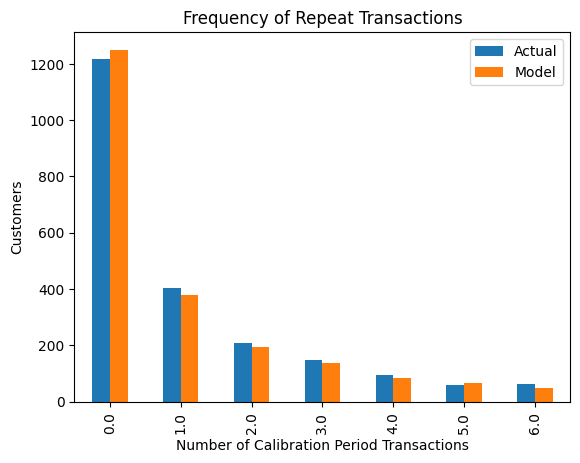

In [41]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

lft = ParetoNBDFitter()
lft.fit(x, t_x, T)
lt_fit = dict(lft.params_)

plot_period_transactions(lft)

lt_fit

Use the `ParetoNBD` distribution from `pymc-marketing` to simulate frequency and recency from fitted Lifetimes model parameters. This is useful for generating synthetic data as well as checking how well the parameters fit the original data.

This forms the basis of the `plot_period_transactions` plot from `lifetimes`.

In [42]:

rec_freq = pm.draw(ParetoNBD.dist(r=0.55,
                alpha=10.58,
                s=0.61,
                beta=11.67,
                T=df.T,
                                 ))

pd.DataFrame({'frequency': rec_freq[...,1], 'recency': rec_freq[...,0], "T": T}).describe()

,frequency,recency,T
count,1.0,1.0,1.0
mean,0.0,0.0,200.0
std,NaN,NaN,NaN
min,0.0,0.0,200.0
25%,0.0,0.0,200.0
50%,0.0,0.0,200.0
75%,0.0,0.0,200.0
max,0.0,0.0,200.0


<Axes: >

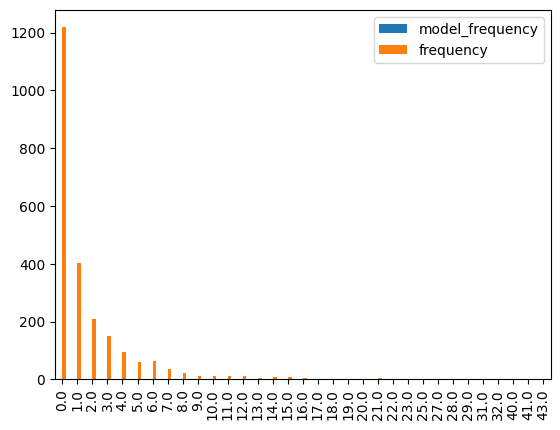

In [43]:
model_freq = rec_freq[...,1]

actual_counts = pd.Series(x).value_counts().sort_index()
simulated_counts = pd.Series(model_freq).value_counts().sort_index()
combined_counts = pd.DataFrame({"model_frequency": simulated_counts, "frequency": actual_counts}).fillna(0)
combined_counts.plot(kind="bar")

## PyMC Comparison

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

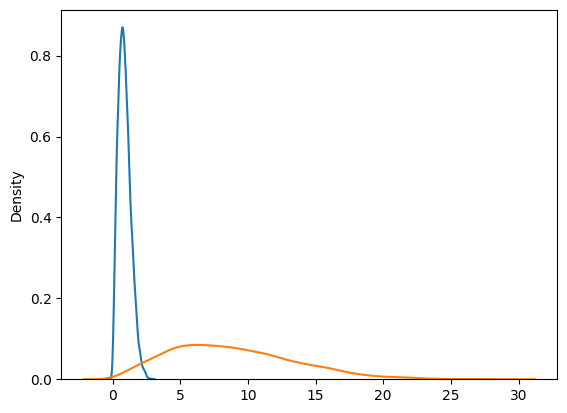

In [44]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [76]:
model_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

map_fit = ParetoNBDModel(df)
map_fit.fit()

lt_fit = {
    'r': 0.5532631052128189,
     'alpha': 10.577412770186461,
     's': 0.6062085898176242,
     'beta': 11.668105047300301,
    }

print("MAP Fit:") 
print(map_fit.fit_summary())

#pm.model_to_graphviz(map_fit)

# TODO: Could this be used to streamline the distribution generation code?
with map_fit.model:
    purchase = pm.Gamma(
                "population_purchase_rate", alpha=map_fit.model.r, beta=1 / map_fit.model.alpha
            )
    dropout = pm.Gamma("population_dropout", alpha=map_fit.model.s, beta=1 / map_fit.model.beta)


MAP Fit:
r         0.465
alpha    62.498
s         0.250
beta     25.145
Name: value, dtype: float64


In [46]:
map_fit = ParetoNBDModel(df)

# TODO: build_model() and fit() methods both return NoneType objects. 
#pnbd.idata not yet created at this point

# pnbd.sample_prior_predictive() can be used after calling build_model and before fitting, 
# it will return an xarray.Dataset, but also create the pnbd.idata arviz.InferenceData object
#map_fit.sample_prior_predictive()

# fitting the model will overwrite the prior_predictive idata object
map_fit.fit(fit_method='map')

assert map_fit.fit_result == map_fit.idata.posterior

map_fit.idata

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [53]:
# fit same model with MCMC to compare return arviz outputs
# Note that HalFlat priors take a very long time to sample
mcmc_fit = ParetoNBDModel(df)
mcmc_fit.fit(fit_method='mcmc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 185 seconds.


In [54]:
# posterior predictive checks not directly supported,
# because GammaGammaModel and BetaGeoModel use Potentials to calculate logp
with mcmc_fit.model:
    post_idata = pm.sample_posterior_predictive(mcmc_fit.idata)

mcmc_fit.idata.extend(post_idata)
mcmc_fit.idata

Sampling: [likelihood]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data
	> posterior_predictive

In [55]:
mcmc_fit.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.468,0.026,0.419,0.517,0.001,0.00,2167.0,2328.0,1.0
alpha,62.777,3.388,56.264,68.716,0.071,0.05,2246.0,2452.0,1.0
s,0.253,0.021,0.215,0.294,0.000,0.00,1944.0,2125.0,1.0
beta,25.913,4.479,17.559,34.326,0.100,0.07,1998.0,2491.0,1.0


array([<Axes: title={'center': 'r'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 's'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

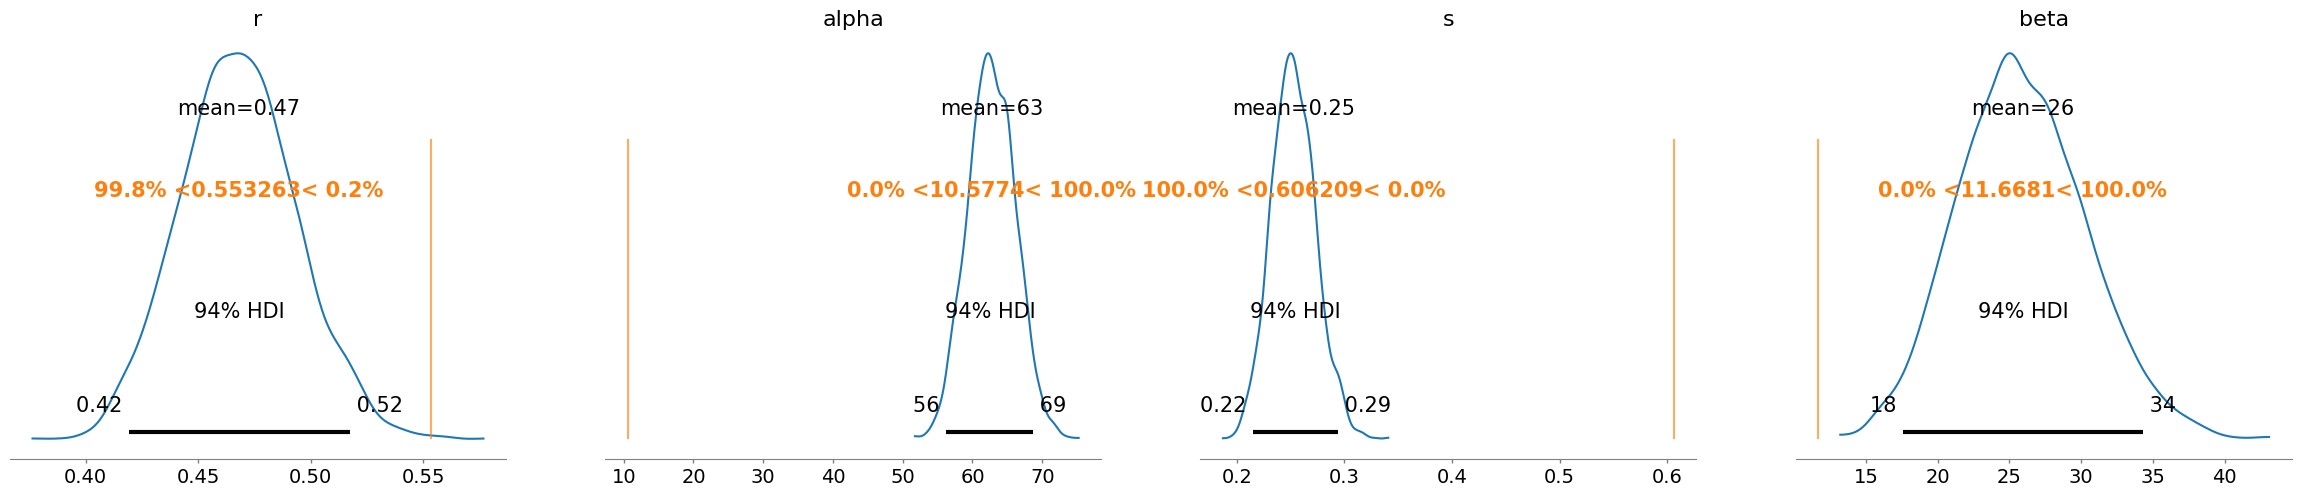

In [56]:
az.plot_posterior(mcmc_fit.idata, ref_val=list(lt_fit.values()))

In [9]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

AttributeError: 'InferenceData' object has no attribute 'prior_predictive'

In [ ]:
post_pred_freq = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_post_pred = pd.DataFrame({"prior_predictive": post_pred_freq, "observed": obs_freq})
plot_post_pred.plot(kind="bar", title = "Plot Post Predictive")

#az.plot_dist(post_idata.posterior_predictive)


In [ ]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
prior_pred_freq_array = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot")
az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Prior Predictive ECDF Plot")

In [ ]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
post_pred_freq_array = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot")
az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Posterior Predictive ECDF Plot")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [10]:
customer_dropout_mcmc = mcmc_fit.distribution_new_customer_dropout()
customer_purchase_rate_mcmc = mcmc_fit.distribution_new_customer_purchase_rate()
customer_population_mcmc = mcmc_fit.distribution_customer_population()

customer_dropout_map = map_fit.distribution_new_customer_dropout()
customer_purchase_rate_map = map_fit.distribution_new_customer_purchase_rate()
customer_population_map = map_fit.distribution_customer_population()


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


In [30]:
customer_dropout_mcmc.shape

#(1, 1, 2357, 2)
#(4, 1000, 2357, 2)


(4, 1000)

In [23]:
N = 2357
chains = 2
draws = 50

rng = np.random.default_rng(34)

mock_idata = az.from_dict(
    {
        "r": rng.normal(0.55, 1e-3, size=(chains, draws)),
        "alpha": rng.normal(
           10.56, 1e-3, size=(chains, draws)
        ),
        "s": rng.normal(.68, 1e-3, size=(chains, draws)),
        "beta": rng.normal(
            11.68, 1e-3, size=(chains, draws)
        ),
    }
)

mock_idata = az.from_dict(
                {
                    "r": .55,
                    "alpha": 10.56,
                    "s": .68,
                    "beta": 11.68,
                }
            )



fake_model = ParetoNBDModel(df)
fake_model.idata=mock_idata

fake_model.distribution_customer_population(T=np.tile(100,1000))

# obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
# prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

Sampling: [customer_population]


Inference data with groups:
	> posterior

Text(0.5, 1.0, 'Customer Dropout Distribution')

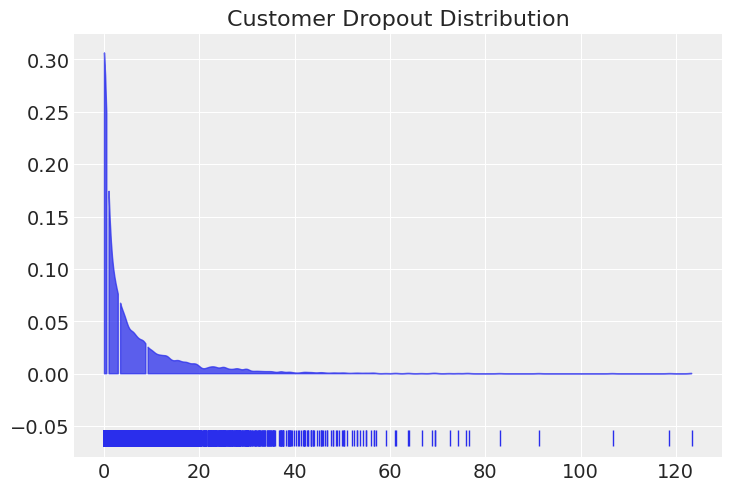

In [111]:
az.plot_dist(customer_dropout_mcmc, rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

Text(0.5, 1.0, 'Customer Dropout Rate Distribution w/ MAP Fit')

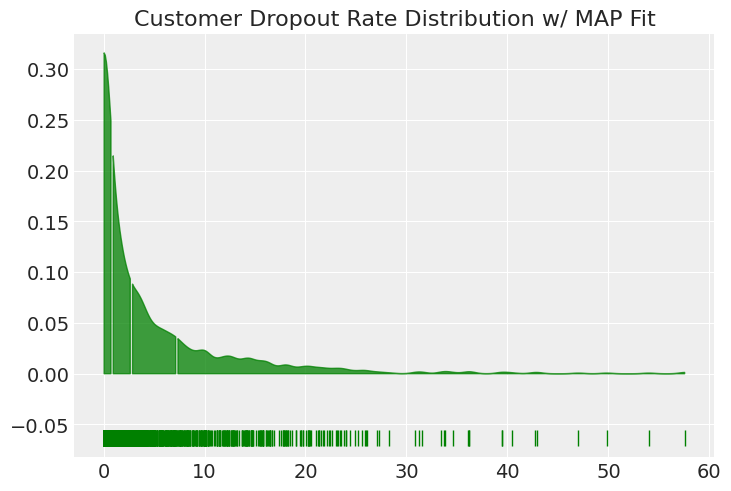

In [112]:
# Note the array indexing required for MAP fit plotting
az.plot_dist(customer_dropout_map[0][0], rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Rate Distribution w/ MAP Fit")

In [34]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
#prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()
customer_population_map

# actual_counts = pd.Series(x).value_counts().sort_index()
# simulated_counts = pd.Series(model_freq).value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<xarray.DataArray 'customer_population' (chain: 4, draw: 1000,
                                         customer_population_dim_2: 2357,
                                         customer_population_dim_3: 2)>
array([[[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [33.22348507,  3.        ],
         [17.78219702,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [15.12256784,  1.        ]],

        [[36.55367967,  5.        ],
         [30.82568583,  2.        ],
         [ 0.        ,  0.        ],
         ...,
...
         ...,
         [ 0.        ,  0.        ],
         [19.43196482,  3.        ],
         [ 0.        ,  0.        ]],

        [[36.3525494 ,  6.        ],
         [ 0.        ,  0.        ],
         [38.4767482 , 12.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [26.8154956 , 10.        ]],

        [[ 0.        ,  0.        ],
         [33.953614  ,  7.        ],
         [19.74782928,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 6.49108868,  1.        ],
         [13.13369364,  4.        ]]]])
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * customer_population_dim_2  (customer_population_dim_2) int64 0 1 ... 2356
  * customer_population_dim_3  (customer_population_dim_3) int64 0 1

# Prior Predictive Plots for the Latent Dropout and Purchase Rate Distributions  are doable, but not directly supported. It's also important to know that since both distributions have identical Priors, there is no difference in plotting between them.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

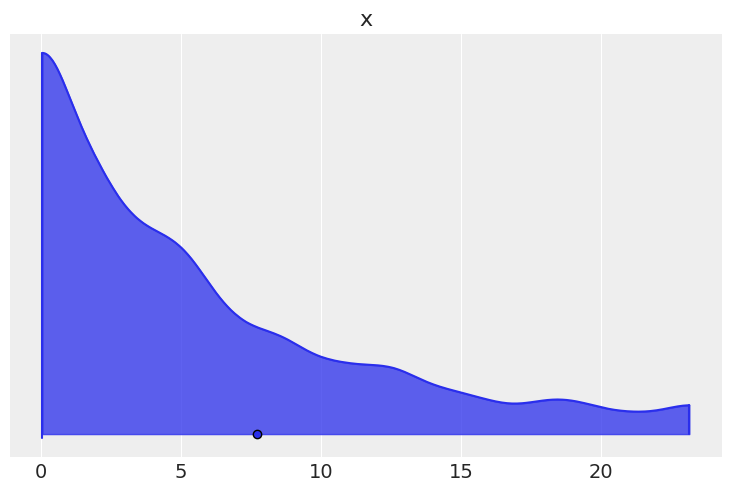

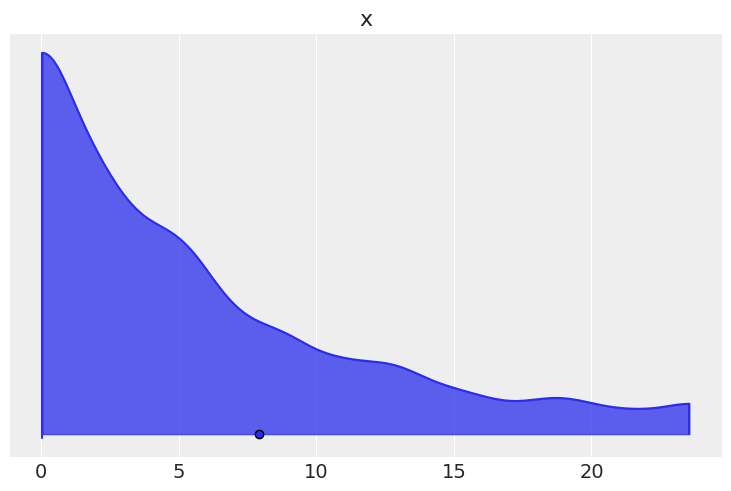

In [204]:
r_prior = mcmc_fit.idata.prior["r"]
alpha_prior = mcmc_fit.idata.prior["alpha"]
s_prior = mcmc_fit.idata.prior["s"]
beta_prior = mcmc_fit.idata.prior["beta"]

purchase_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=r_prior.values[..., None].mean(),  
        beta=1 / alpha_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

dropout_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=s_prior.values[..., None].mean(),  
        beta=1 / beta_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

az.plot_density(purchase_rate_dist,point_estimate="mean", shade=.75)
az.plot_density(dropout_rate_dist,point_estimate="mean", shade=.75)

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
